# @title
### EP2 MAC0417 / MAC5768
##################################################################
# AO PREENCHER ESSE CABEÇALHO COM O MEU NOME E O MEU NÚMERO USP,#
# DECLARO QUE SOU O ÚNICO AUTOR E RESPONSÁVEL PELA RESOLUÇÃO #
# DESTE EP. #
# TODAS AS PARTES FORAM DESENVOLVIDAS E IMPLEMENTADAS POR MIM, #
# SEGUINDO AS INSTRUÇÕES E QUE PORTANTO, NÃO CONSTITUEM #
# DESONESTIDADE ACADÊMICA OU PLÁGIO. #
# #
# DECLARO TAMBÉM, QUE SOU RESPONSÁVEL POR TODAS AS CÓPIAS #
# DESSE PROGRAMA, E QUE EU NÃO DISTRIBUI OU FACILITEI A #
# SUA DISTRIBUIÇÃO. ESTOU CIENTE QUE OS CASOS DE PLÁGIO E #
# DESONESTIDADE ACADÊMICA SERÃO TRATADOS SEGUNDO OS CRITÉRIOS #
# DEFINIDOS NO CÓDIGO DE ÉTICA DA USP. #
# #
# ENTENDO QUE JUPYTER NOTEBOOKS SEM ASSINATURA NÃO SERÃO #
# CORRIGIDOS E, AINDA ASSIM, PODERÃO SER PUNIDOS POR #
# DESONESTIDADE ACADÊMICA. #
# #
# #
# Nome : Luca Diogo da Silva
# NUSP : 12542693
# Turma: BCC
# Prof.: Ronaldo
##################################################################

In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

outer_path = ""

## Comprimindo as imagens


In [2]:
parent = os.path.join(outer_path,"datasets")
new_path = os.path.join(parent, "compressedImages")
if not os.path.isdir(new_path):
    os.mkdir(new_path)
source_path = os.path.join(parent, "originalImages")
for img in os.listdir(source_path):
    img_path = os.path.join(source_path, img)
    img_mat = cv2.imread(img_path)
    img_redux = cv2.resize(img_mat, (0,0), fx=0.4, fy=0.4)
    
    number = img.split(".")[0]
    cv2.imwrite(os.path.join(new_path, f"{number}.jpg"), img_redux)


## Convertendo para escala de cinza

In [3]:
source_path = os.path.join(parent, "compressedImages")
new_path = os.path.join(parent, "originalGrayDataset")

if not os.path.isdir(new_path):
    os.mkdir(new_path)

for img in os.listdir(source_path):
    img_path = os.path.join(source_path, img)
    img_mat = cv2.imread(img_path)
    
    img_gray = cv2.cvtColor(img_mat, cv2.COLOR_BGR2GRAY)
    
    number = img.split(".")[0]
    cv2.imwrite(os.path.join(new_path, f"{number}.jpg"), img_gray)


## Contrast Stretching

In [4]:
source_path = os.path.join(parent, "originalGrayDataset")
augmented_path = os.path.join(parent, "augmentedDataset")

images = [[] for i in range(len(os.listdir(source_path)))]
n = len(images)
print(n)
if not os.path.isdir(augmented_path):
    os.mkdir(augmented_path)

new_path = os.path.join(augmented_path, "contrastStretching")

if not os.path.isdir(new_path):
    os.mkdir(new_path)
    
for img in os.listdir(source_path):
    img_path = os.path.join(source_path, img)
    img_mat = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(float)
    number = img.split(".")[0]
    images[int(number)-1] = img_mat

for i in range(n):
    img_mat = images[i]
    min = np.min(img_mat)
    max = np.max(img_mat)
    contrast = (img_mat - min) * 255 / (max-min)
    cv2.imwrite(os.path.join(new_path, f"{i+1}.jpg"), contrast)




45


## Transformação logarítmica e exponencial

Os hiperparâmetros foram escolhidos com base em experimentação


In [5]:
def hiperparametro(op, ilum):
    op = 0 if (op == "exp") else 1
    ilum_map = {
        "dentro de casa - dia": [0.8, 20.0],
        "fora de casa - dia": [2.7, 35.0],
        "dentro de casa - noite":[0.6, 30.0],
        "fora de casa - noite":[0.5, 40.0]
    }
    
    return ilum_map[ilum][op]


exp_path = os.path.join(augmented_path, "exponencial")
if not os.path.isdir(exp_path):
    os.mkdir(exp_path)

log_path = os.path.join(augmented_path, "logaritmo")
if not os.path.isdir(log_path):
    os.mkdir(log_path)

df = pd.read_csv("metadados.csv")


for i in range(n):
    img_mat = images[i]
    ilum = df["Iluminacao"].iloc[i]
    gamma = hiperparametro("exp", ilum)
    
    exp = np.power(img_mat, gamma)
    min = np.min(exp); max = np.max(exp)
    exp -= min
    exp *= (255 / (max-min))
    exp = np.floor(exp).astype(np.uint8)
    cv2.imwrite(os.path.join(exp_path, f"{i+1}.jpg"), exp)

    gamma = hiperparametro("log", ilum)

    log = gamma * np.log(img_mat+1)
    log = np.floor(np.minimum(255, log)).astype(np.uint8)
    cv2.imwrite(os.path.join(log_path, f"{i+1}.jpg"), log)


## Laplaciano


In [6]:
def centralizacao(mat):
    n, m = mat.shape
    for i in range(n):
        for j in range(m):
            if (i+j) % 2 == 1:
                mat[i, j] *= -1

    return mat

def prepara_kernel(kernel, n, m):
    kn, km = kernel.shape
    kernel = np.pad(kernel, [(0, int(2*n - kn)), (0, int(2*m - km))])
    kernel = centralizacao(kernel)
    
    return np.fft.fft2(kernel)


def convolucao(kernel, img):
    # realiza convolução multiplicando no domínio da frequência
    # supoe kernel no dominio da frequencia (pre-processado)
    n, m = img.shape

    img = np.pad(img, [(0, int(n)), (0, int(m))], "constant")
    img = centralizacao(img)

    img_freq = np.fft.fft2(img)
    img_freq = kernel * img_freq

    result = np.fft.ifft2(img_freq)[0:n, 0:m]
    result = centralizacao(result.real)
    return result


In [7]:
laplace_path = os.path.join(augmented_path, "laplace")
if not os.path.isdir(laplace_path):
    os.mkdir(laplace_path)

x, y = images[0].shape #todas as imagens possuem as mesmas dimensões

kernel = np.array(([0, 1, 0], [1, -4, 1], [0, 1, 0]))
kernel_freq = prepara_kernel(kernel, x, y)

for i in range(n):
    img_mat = images[i]
    
    laplace = convolucao(kernel_freq, img_mat)
    img_realcada = np.clip(img_mat - laplace, 0, 255)

    cv2.imwrite(os.path.join(laplace_path, f"{i+1}.jpg"), img_realcada)
    

## Filtro da média

In [8]:

media_path = os.path.join(augmented_path, "media")
if not os.path.isdir(media_path):
    os.mkdir(media_path)

kernel = np.ones(shape=(11, 11)) / 121
kernel_freq = prepara_kernel(kernel, x, y)

for i in range(n):
    img_mat = images[i]

    img_blur = convolucao(kernel_freq, img_mat)
    cv2.imwrite(os.path.join(media_path, f"{i+1}.jpg"), img_blur)
    

## Visualização de dataset

datasets/augmentedDataset/laplace


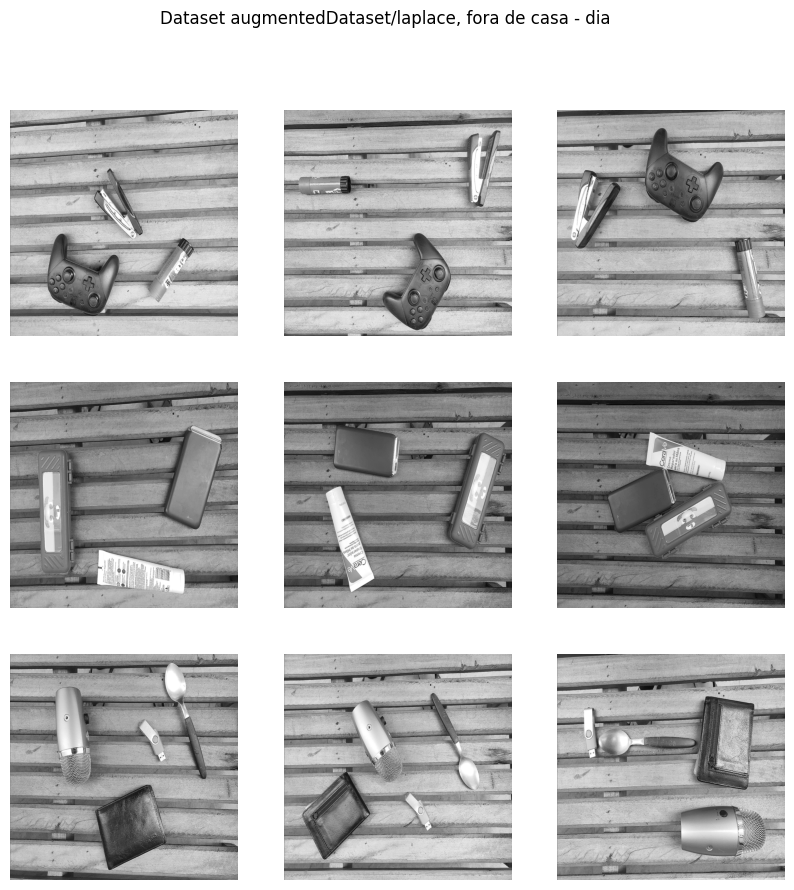

In [9]:
def visualiza_dataset(parent, df, dataset, ilum):
    img_indices = df[df["Iluminacao"] == ilum].index + 1
    n = len(img_indices)

    linhas = 3
    cols = int(n / 3)
    fig, axes = plt.subplots(linhas, cols, figsize=(int((cols / linhas) * 10), 10))
    fig.suptitle(f"Dataset {dataset}, {ilum}")

    
    src_path = os.path.join(parent, dataset)
    print(src_path)

    i = 0
    for ax in axes.flat:
       img = cv2.imread(os.path.join(src_path, f"{img_indices[i]}.jpg"), cv2.IMREAD_GRAYSCALE).astype(int) 
       ax.imshow(img, cmap='gray', vmin=0, vmax=255)
       ax.set_aspect("auto")
       ax.axis('off')
       i += 1

    plt.show()



visualiza_dataset(parent, df, os.path.join("augmentedDataset", "laplace"), "fora de casa - dia")